# Ensemble Learning of a Hidden Markov Model
### (This demo is the translation of the [ForneyLab](https://github.com/biaslab/ForneyLab.jl/blob/master/demo/hidden_markov_model_estimation.ipynb) demo on hidden Markov model)
In this demo we are interested in Bayesian inference of parameters of a hidden Markov model (HMM).,
Specifically, we consider a first-order HMM with hidden states $s_0, s_1, \dots, s_T$ and observations $x_1, \dots, x_T$ governed by a state transition probability matrix $A$ and an observation probability matrix $B$:,
    \begin{align*}
        s_t & \sim \mathcal{C}at(A s_{t-1}),\\
        x_t & \sim \mathcal{C}at(B s_t).\\,
    \end{align*}

We assume three possible states (\"red\", \"green\" and \"blue\"), and the goal is to estimate matrices $A$ and $B$ from a simulated data set. To have a full Bayesian treatment of the problem, both $A$ and $B$ are endowed with priors (Dirichlet distributions on the columns)."

In [1]:
using Rocket, ReactiveMP, GraphPPL
using Random, BenchmarkTools, Distributions, MacroTools, LinearAlgebra
using Plots

In [2]:
function rand_vec(rng, distribution::Categorical) 
    k = ncategories(distribution)
    s = zeros(k)
    s[ rand(rng, distribution) ] = 1.0
    s
end

function generate_data(n_samples; seed = 124)
    
    rng = MersenneTwister(seed)
    
    # Transition probabilities (some transitions are impossible)
    A = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9] 
    # Observation noise
    B = [0.9 0.05 0.05; 0.05 0.9 0.05; 0.05 0.05 0.9] 
    # Initial state
    s_0 = [1.0, 0.0, 0.0] 
    # Generate some data
    s = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
    x = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the observations
    
    s_prev = s_0
    
    for t = 1:n_samples
        a = A * s_prev
        s[t] = rand_vec(rng, Categorical(a ./ sum(a)))
        b = B * s[t]
        x[t] = rand_vec(rng, Categorical(b ./ sum(b)))
        s_prev = s[t]
    end
    
    return x, s
end

generate_data (generic function with 1 method)

In [3]:
# Test data
N = 100
x_data, s_data = generate_data(N);

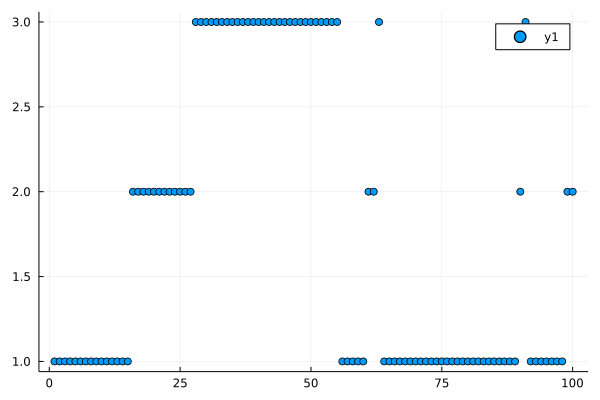

In [4]:
scatter(argmax.(s_data))

In [5]:
# Model specification
@model function hidden_markov_model(n)
    
    A ~ MatrixDirichlet(ones(3, 3)) 
    B ~ MatrixDirichlet([ 10.0 1.0 1.0; 1.0 10.0 1.0; 1.0 1.0 10.0 ])
    
    s_0 ~ Categorical(fill(1.0 / 3.0, 3))
    
    s = randomvar(n)
    x = datavar(Vector{Float64}, n)
    
    s_prev = s_0
    
    for t in 1:n
        s[t] ~ Transition(s_prev, A) 
        x[t] ~ Transition(s[t], B)
        s_prev = s[t]
    end
    
end

@constraints function hidden_markov_model_constraints()
    q(s_0, s, A, B) = q(s_0, s)q(A)q(B)
end

hidden_markov_model_constraints (generic function with 1 method)

In [16]:

idata = (x = x_data, )

imodel = Model(hidden_markov_model, N)

imarginals = (
    A = vague(MatrixDirichlet, 3, 3), 
    B = vague(MatrixDirichlet, 3, 3), 
    s = vague(Categorical, 3)
)

ireturnvars = (
    A = KeepLast(),
    B = KeepLast(),
    s = KeepLast()
)

result = inference(
    model         = imodel, 
    data          = idata,
    options       = options,
    constraints   = hidden_markov_model_constraints(),
    initmarginals = imarginals, 
    returnvars    = ireturnvars, 
    iterations    = 20, 
    free_energy   = true
);

In [17]:
mean(result.posteriors[:A])

3×3 Matrix{Float64}:
 0.892911   0.0830398  0.133822
 0.0858821  0.691112   0.042798
 0.0212073  0.225849   0.82338

In [18]:
mean(result.posteriors[:B])

3×3 Matrix{Float64}:
 0.908176   0.0422229  0.0718142
 0.0694807  0.882211   0.0430307
 0.0223437  0.0755656  0.885155

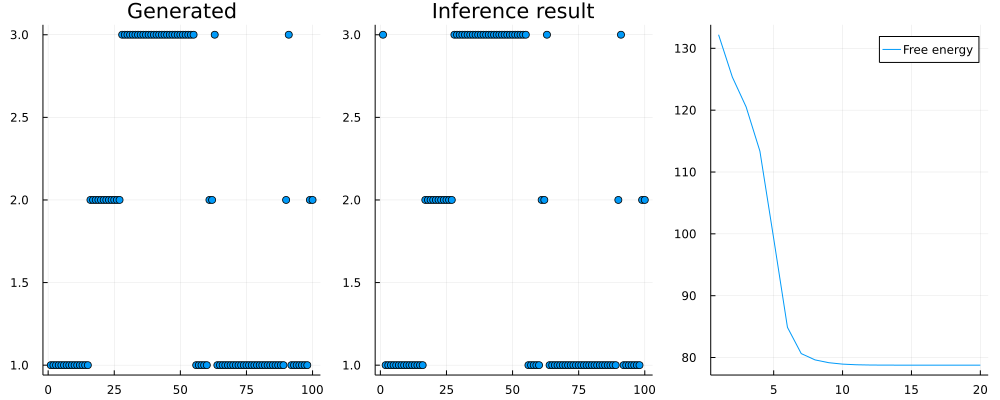

In [30]:
p1 = scatter(argmax.(s_data), title="Generated", legend=false)
p2 = scatter(argmax.(ReactiveMP.probvec.(result.posteriors[:s])), title="Inference result", legend=false)
p3 = plot(result.free_energy, label="Free energy")

plot(p1, p2, p3, size = (1000, 400), layout = @layout([ a b c ]))

## Custom inference

In [31]:
@model [ default_factorisation = MeanField() ] function custom_optimised_hidden_markov_model(n)
    
    A ~ MatrixDirichlet(ones(3, 3)) 
    B ~ MatrixDirichlet([ 10.0 1.0 1.0; 1.0 10.0 1.0; 1.0 1.0 10.0 ])
    
    s_0 ~ Categorical(fill(1.0 / 3.0, 3))
    
    s = randomvar(n)
    x = datavar(Vector{Float64}, n)
    
    s_prev = s_0
    
    for t in 1:n
        s[t] ~ Transition(s_prev, A) where { q = q(out, in)q(a) }
        x[t] ~ Transition(s[t], B)
        s_prev = s[t]
    end
    
    return s, x, A, B
end

In [21]:
function custom_optimised_inference(data, vmp_iters)
    n = length(data)
    
    model, (s, x, A, B) = custom_optimised_hidden_markov_model(model_options(limit_stack_depth = 500), n)
    
    sbuffer = keep(Vector{Marginal})
    Abuffer = keep(Marginal)
    Bbuffer = keep(Marginal)
    fe      = ScoreActor(Float64)
    
    ssub  = subscribe!(getmarginals(s), sbuffer)
    Asub  = subscribe!(getmarginal(A), Abuffer)
    Bsub  = subscribe!(getmarginal(B), Bbuffer)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)
    
    setmarginal!(A, vague(MatrixDirichlet, 3, 3))
    setmarginal!(B, vague(MatrixDirichlet, 3, 3))
    
    foreach(s) do svar
        setmarginal!(svar, vague(Categorical, 3))
    end
    
    for i in 1:vmp_iters
        update!(x, data)
    end
    
    unsubscribe!(ssub)
    unsubscribe!(Asub)
    unsubscribe!(Bsub)
    unsubscribe!(fesub)
    
    return map(getvalues, (sbuffer, Abuffer, Bbuffer, fe))
end

custom_optimised_inference (generic function with 1 method)

In [22]:
sbuffer, Abuffer, Bbuffer, fe = custom_optimised_inference(x_data, 20);

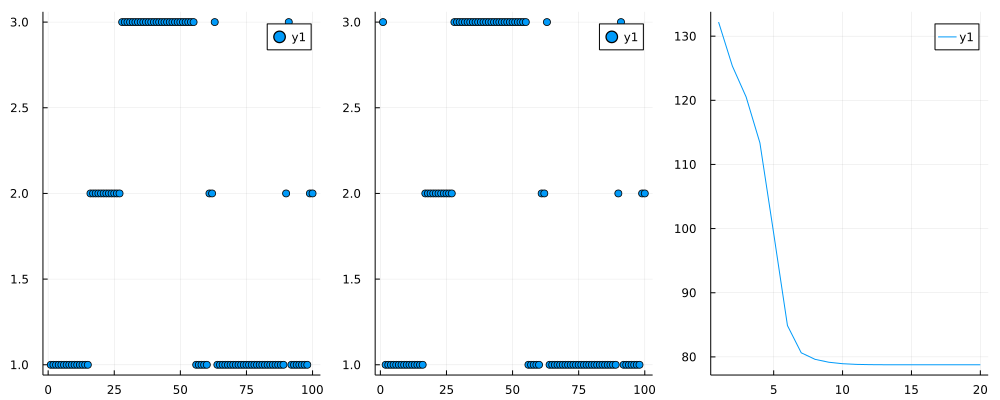

In [23]:
p1 = scatter(argmax.(s_data), title="Generated", legend=false)
p2 = scatter(argmax.(ReactiveMP.probvec.(result.posteriors[:s])), title="Inference result", legend=false)
p3 = plot(result.free_energy, label="Free energy")

plot(p1, p2, p3, size = (1000, 400), layout = @layout([ a b c ]))

In [32]:
@assert mean.(last(sbuffer)) ≈ mean.(result.posteriors[:s])

# Benchmark timings

In [37]:
@time inference(
    model         = imodel, 
    data          = idata,
    options       = options,
    constraints   = hidden_markov_model_constraints(),
    initmarginals = imarginals, 
    returnvars    = ireturnvars, 
    iterations    = 20, 
    free_energy   = true
);

@time inference(
    model         = imodel, 
    data          = idata,
    options       = options,
    constraints   = hidden_markov_model_constraints(),
    initmarginals = imarginals, 
    returnvars    = ireturnvars, 
    iterations    = 20, 
    free_energy   = true
);

  0.055611 seconds (444.30 k allocations: 32.019 MiB)
  0.035698 seconds (444.30 k allocations: 32.019 MiB)


In [39]:
@benchmark inference(
    model         = $imodel, 
    data          = $idata,
    options       = $options,
    constraints   = hidden_markov_model_constraints(),
    initmarginals = $imarginals, 
    returnvars    = $ireturnvars, 
    iterations    = 20, 
    free_energy   = true
);

In [40]:
@time sbuffer, Abuffer, Bbuffer, fe = custom_optimised_inference(x_data, 20);
@time sbuffer, Abuffer, Bbuffer, fe = custom_optimised_inference(x_data, 20);

  0.134176 seconds (839.17 k allocations: 55.999 MiB, 78.60% compilation time)
  0.043959 seconds (414.68 k allocations: 30.501 MiB, 30.03% gc time)


In [41]:
@benchmark custom_optimised_inference($x_data, 20)

BenchmarkTools.Trial: 140 samples with 1 evaluation.
 Range (min … max):  28.759 ms … 48.831 ms  ┊ GC (min … max):  0.00% … 26.88%
 Time  (median):     33.251 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   35.858 ms ±  5.890 ms  ┊ GC (mean ± σ):  10.14% ± 11.72%

  █▄▂▂▆▆▄▂▄▂▄▄▂█▆                   ▂                 ▂        
  ███████████████▄▆██▄▁▁▄▁▁▄▁▁▁▄▁▁▄████▄▆▆▆█▆▆▄▁▆▄█▁█▆█▆▄▁▄▁▄ ▄
  28.8 ms         Histogram: frequency by time        48.1 ms <

 Memory estimate: 30.50 MiB, allocs estimate: 414671.